In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sys

from pathlib import Path

pd.set_option("display.max_columns", None)

In [2]:
root_path = str(Path.cwd().parent)
if root_path not in sys.path:
    sys.path.append(root_path)

from utils import preencher_nulos
from utils import formatar_eixo_ano

In [3]:
df = pd.read_parquet("../arquivos_parquet/dados_base.parquet")
df

,Date,Close,High,Low,Open,Volume,Variacao,Var%
0,2022-01-03,12.387838,12.579601,12.170507,12.330310,1461343,NaN,NaN
1,2022-01-04,12.662697,12.688264,12.368661,12.368661,1115778,0.274858,2.218777
2,2022-01-05,12.407015,12.726618,12.387838,12.643520,984350,-0.255682,-2.019175
3,2022-01-06,12.630733,12.656301,12.368659,12.598774,2113838,0.223718,1.803155
4,2022-01-07,12.828888,12.848064,12.438971,12.681870,1116684,0.198155,1.568835
...,...,...,...,...,...,...,...,...
994,2025-12-22,35.335915,35.568706,35.258320,35.462010,1940108,-0.126095,-0.355577
995,2025-12-23,35.743301,35.849998,35.403813,35.549307,889817,0.407387,1.152897
996,2025-12-26,36.016346,36.056310,35.666674,35.816532,554500,0.273045,0.763904
997,2025-12-29,35.966396,36.146229,35.776575,36.016349,627500,-0.049950,-0.138686


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      999 non-null    object 
 1   Close     999 non-null    float64
 2   High      999 non-null    float64
 3   Low       999 non-null    float64
 4   Open      999 non-null    float64
 5   Volume    999 non-null    int64  
 6   Variacao  998 non-null    float64
 7   Var%      998 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 62.6+ KB


In [5]:
col_nulo = ["Variacao", "Var%"]

df = preencher_nulos(df, col_nulo, 0)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,999.0,20.134537,6.014169,12.360322,14.835427,19.757898,23.461493,3.631607e+01
High,999.0,20.318123,6.047612,12.398887,15.008588,19.893750,23.677168,3.667573e+01
Low,999.0,19.936897,5.967382,12.122500,14.670843,19.639428,23.269133,3.601635e+01
Open,999.0,20.118871,6.005802,12.330310,14.815571,19.754492,23.488877,3.613718e+01
Volume,999.0,723664.808809,471599.261821,122364.000000,436827.500000,602416.000000,870766.500000,4.956875e+06
Variacao,999.0,0.023952,0.260465,-1.441841,-0.123307,0.017794,0.164771,1.326288e+00
Var%,999.0,0.115973,1.287265,-5.096309,-0.639625,0.095070,0.844370,6.547328e+00


In [7]:
inicio = df["Date"].min()
fim = df["Date"].max()

print(f"Data inicial: {inicio}")
print(f"Data final: {fim}")

Data inicial: 2022-01-03
Data final: 2025-12-30


In [8]:
plt.rcParams["figure.figsize"] = (
    12,
    6,
)  # Tamanho padrão para todos os gráficos
plt.rcParams["axes.grid"] = True  # Ativa grade em todos
plt.rcParams["grid.alpha"] = 0.3  # Transparência da grade
plt.rcParams["axes.titlesize"] = 14  # Tamanho da fonte do título

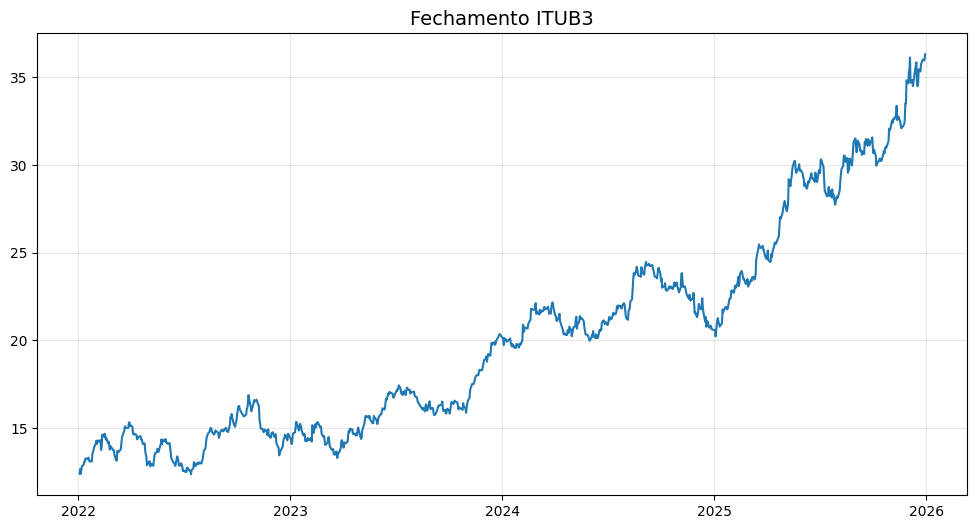

In [ ]:
fig, ax = plt.subplots()
ax.plot(df["Date"], df["Close"])

formatar_eixo_ano(ax)

ax.set_title("Fechamento ITUB3")
plt.show()

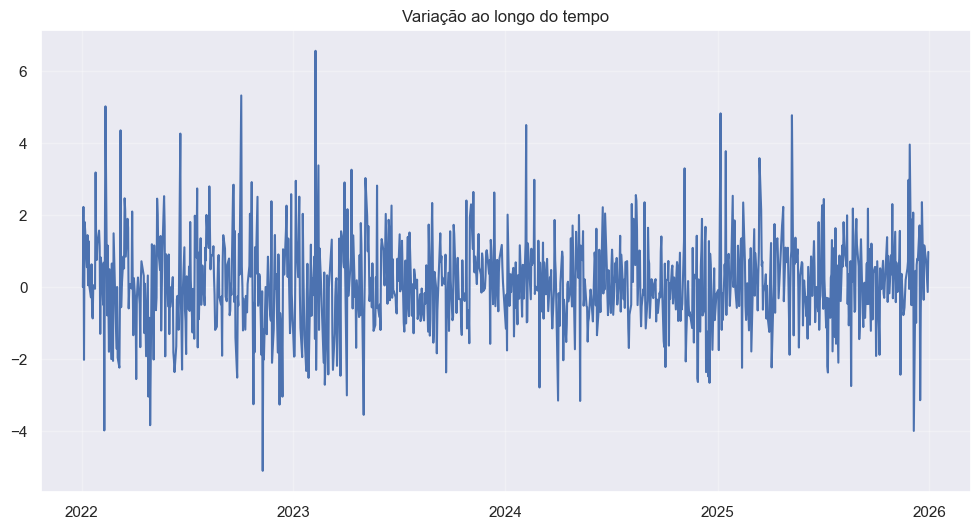

In [ ]:
fig, ax = plt.subplots()
ax.plot(df["Date"], df["Var%"])

formatar_eixo_ano(ax)

ax.set_title("Variação ao longo do tempo")
plt.show()

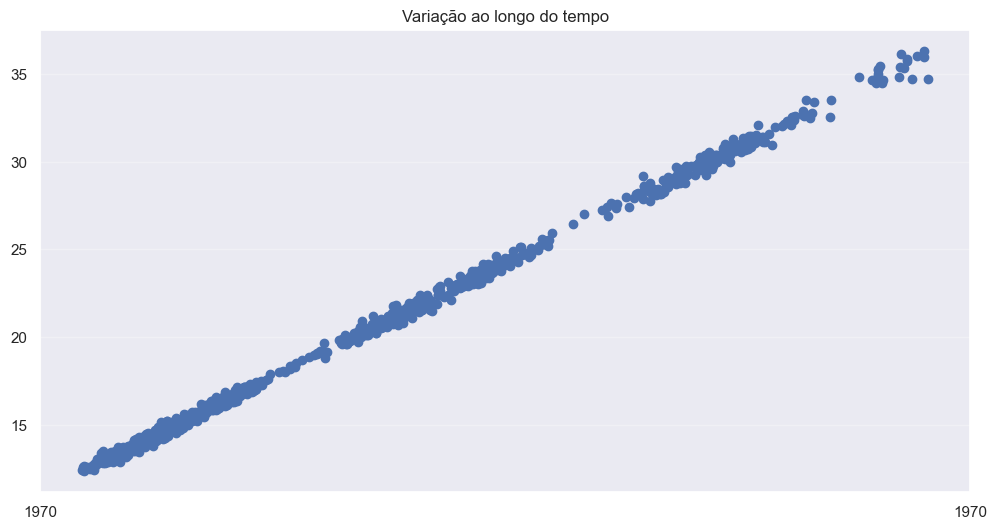

In [ ]:
fig, ax = plt.subplots()
ax.scatter(df["Open"], df["Close"])

formatar_eixo_ano(ax)

ax.set_title("Variação ao longo do tempo")
plt.show()

array([[<Axes: title={'center': 'Close'}>,
        <Axes: title={'center': 'High'}>,
        <Axes: title={'center': 'Low'}>],
       [<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'Volume'}>,
        <Axes: title={'center': 'Variacao'}>],
       [<Axes: title={'center': 'Var%'}>, <Axes: >, <Axes: >]],
      dtype=object)

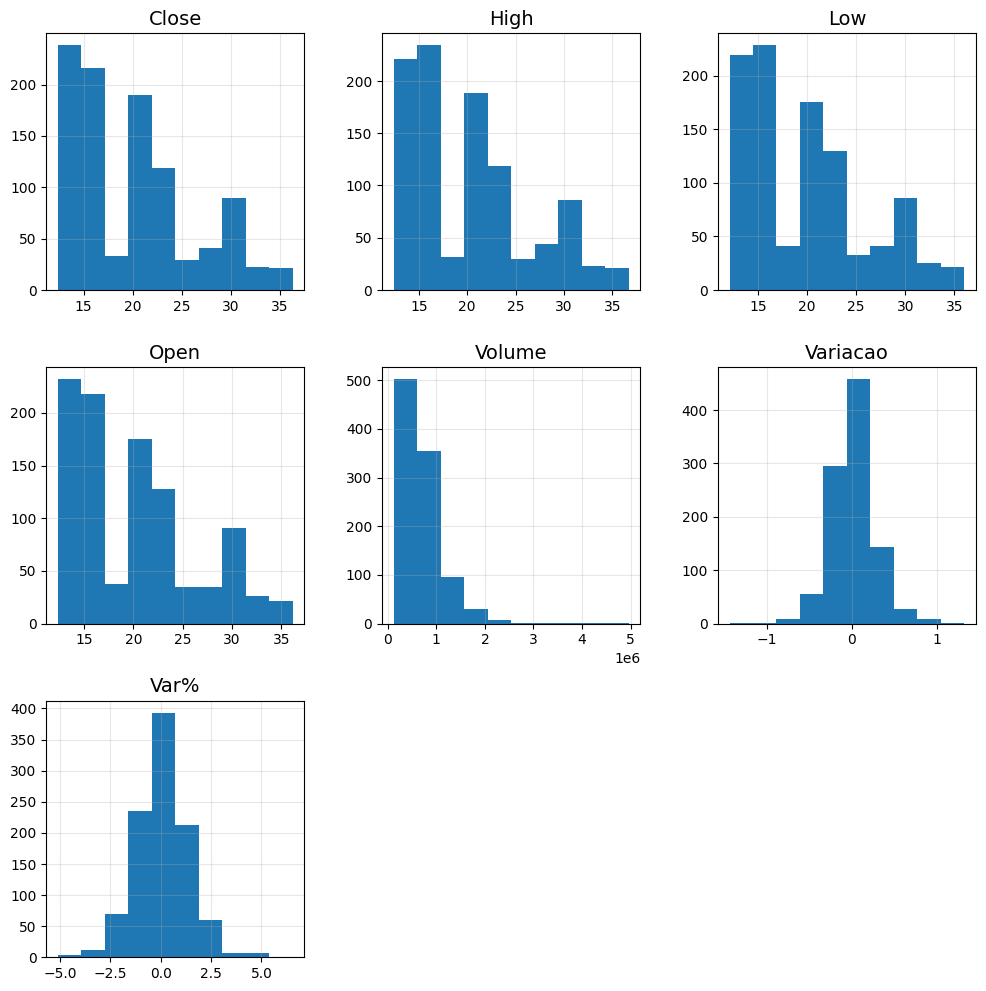

In [13]:
df.hist(figsize=(12, 12))

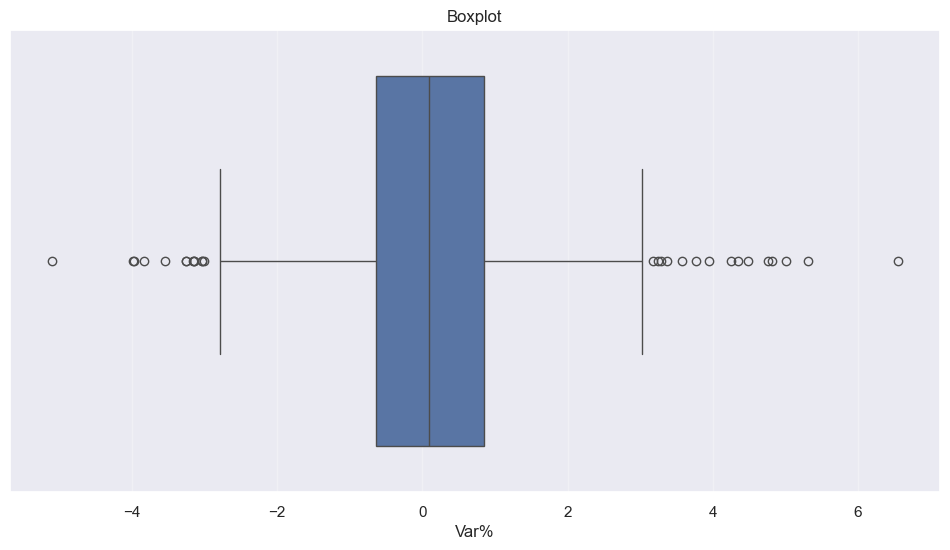

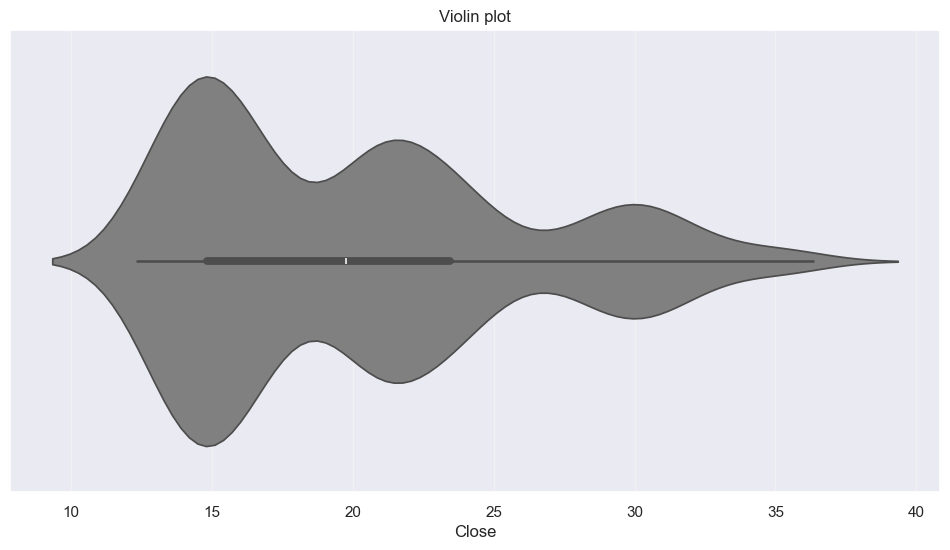

In [14]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(figsize=(12, 6))
sns.boxplot(x="Var%", data=df)
axes.set_title("Boxplot")
plt.show()

fig, axes = plt.subplots(figsize=(12, 6))
sns.violinplot(x="Close", data=df, color="gray")
axes.set_title("Violin plot")
plt.show()